# Model Building and Evaluation

In [1]:
!gdown 198uCuLf26DkECPvHS8GaDM7TD8sQ9RLh
!gdown 1OtHiSNb34oRptjsl-CohoRCGISRKVLaq

Downloading...
From: https://drive.google.com/uc?id=198uCuLf26DkECPvHS8GaDM7TD8sQ9RLh
To: /content/labels-20250212T103318Z-001.zip
100% 3.63M/3.63M [00:00<00:00, 169MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OtHiSNb34oRptjsl-CohoRCGISRKVLaq
From (redirected): https://drive.google.com/uc?id=1OtHiSNb34oRptjsl-CohoRCGISRKVLaq&confirm=t&uuid=9f6a2025-fa01-47e0-bf07-e441b93ad0ff
To: /content/image_chips_native-20250212T103727Z-001.zip
100% 891M/891M [00:09<00:00, 91.0MB/s]


In [2]:
!unzip -q /content/image_chips_native-20250212T103727Z-001.zip
!unzip -q /content/labels-20250212T103318Z-001.zip

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import random
import os
import shutil
from PIL import Image, ImageDraw
from pathlib import Path

## Split the data into 80-20 train-test split. Use 10% of training data as validation

In [4]:
Path("images_data/train").mkdir(parents=True, exist_ok=True)
Path("images_data/val").mkdir(parents=True, exist_ok=True)
Path("images_data/test").mkdir(parents=True, exist_ok=True)
Path("labels_data/train").mkdir(parents=True, exist_ok=True)
Path("labels_data/val").mkdir(parents=True, exist_ok=True)
Path("labels_data/test").mkdir(parents=True, exist_ok=True)

In [5]:
img_dir = "/content/image_chips_native/"
label_dir =  "/content/labels/labels_native/"

In [6]:
train_split = 0.7
validation_split = 0.1
test_split = 0.2

count = len(os.listdir(img_dir))
train_count = int(count * train_split)
validation_count = int(count * validation_split)
test_count = count - train_count - validation_count

print(f"Train images count: {train_count}")
print(f"Validation images count: {validation_count}")
print(f"Test images count: {test_count}")

Train images count: 1787
Validation images count: 255
Test images count: 511


In [7]:
tile1_image_paths = [file for file in sorted(os.listdir(img_dir)) if "solarpanels_native_1" in file]
tile1_label_paths = [file for file in sorted(os.listdir(label_dir)) if "solarpanels_native_1" in file]
tile2_image_paths = [file for file in sorted(os.listdir(img_dir)) if "solarpanels_native_2" in file]
tile2_label_paths = [file for file in sorted(os.listdir(label_dir)) if "solarpanels_native_2" in file]
tile3_image_paths = [file for file in sorted(os.listdir(img_dir)) if "solarpanels_native_3" in file]
tile3_label_paths = [file for file in sorted(os.listdir(label_dir)) if "solarpanels_native_3" in file]

print(f"Tile 1 images: {len(tile1_image_paths)}")
print(f"Tile 1 labels: {len(tile1_label_paths)}")
print("---------")
print(f"Tile 2 images: {len(tile2_image_paths)}")
print(f"Tile 2 labels: {len(tile2_label_paths)}")
print("---------")
print(f"Tile 3 images: {len(tile3_image_paths)}")
print(f"Tile 3 labels: {len(tile3_label_paths)}")

Tile 1 images: 1000
Tile 1 labels: 989
---------
Tile 2 images: 638
Tile 2 labels: 638
---------
Tile 3 images: 915
Tile 3 labels: 915


**NOTE:** On exploring its been obseved that there are `11 labels missing` for `tile_1 images`.To ensure proper data splitting the images corresponding to these labels are eliminated

In [8]:
for img_path in tile1_image_paths:
  if img_path.split(".")[0] + ".txt" not in tile1_label_paths:
    tile1_image_paths.remove(img_path)

In [9]:
# Dataset splitting - Train,Validation and Test

train_split = 0.7
val_split = 0.1
test_split = 0.2

tile1_count = len(tile1_image_paths)
tile2_count = len(tile2_image_paths)
tile3_count = len(tile3_image_paths)

def move_files(images_paths :list, labels_paths : list, train_split :float, val_split : float, test_split : float):

  count = len(images_paths)

  for i,(image_path,label_path) in enumerate(zip(sorted(images_paths),sorted(labels_paths)),1):

    if i<= count * train_split:
      shutil.copy(img_dir+image_path,"images_data/train")
      shutil.copy(label_dir+label_path,"labels_data/train")

    elif i<= count * (train_split + val_split):
      shutil.copy(img_dir+image_path,"images_data/val")
      shutil.copy(label_dir+label_path,"labels_data/val")

    else:
      shutil.copy(img_dir+image_path,"images_data/test")
      shutil.copy(label_dir+label_path,"labels_data/test")

move_files(tile1_image_paths,tile1_label_paths,train_split,val_split,test_split)
move_files(tile2_image_paths,tile2_label_paths,train_split,val_split,test_split)
move_files(tile3_image_paths,tile3_label_paths,train_split,val_split,test_split)

In [10]:
## Visualizing the dataset splits based on Tile number
df = pd.DataFrame(data=None)
def tile_wise_distribution(path : str):
  n1,n2,n3=0,0,0
  for file in os.listdir(f"images_data/{path}"):
    if "solarpanels_native_1" in file:
      n1+=1
    elif "solarpanels_native_2" in file:
      n2+=1
    else:
      n3+=1

  df[path] = {"Tile_1" : n1,
              "Tile_2" : n2,
              "Tile_3" : n3}

tile_wise_distribution("train")
tile_wise_distribution("val")
tile_wise_distribution("test")
print("Visualizing tile wise distribution among the dataset splits\n\n")
df

Visualizing tile wise distribution among the dataset splits




,train,val,test
Tile_1,692,99,198
Tile_2,446,64,128
Tile_3,640,91,184


In [11]:
# Combining the labels and images into single folder and zipping
Path("dataset").mkdir(parents=True, exist_ok=True)

!mv /content/images_data /content/dataset
!mv /content/labels_data /content/dataset
!zip -r -q /content/dataset.zip /content/dataset

### 1. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged.

#### **`NOTE:`** Please note that the model training is performed in a seperate notebook to leverage Kaggle's `MULTI-GPU` support to achieve faster training

### 2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.

In [12]:
# Importing model training files to utilise the fine-tuned YOLO weights
!pip install -q -U ultralytics supervision
!gdown 18Y9p-X6j84XDVg-m4-EevghrSpP_R5K-

!unzip -q /content/runs.zip

!mv /content/kaggle/working/runs /content

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s eta 0:00:00
Downloading...
From (original): https://d

In [270]:
import ipywidgets as widgets
from IPython.display import display
from ultralytics import YOLO

button = widgets.Button(description="View YOLO")

model = YOLO(model="/content/runs/detect/train6/weights/best.pt",verbose=False)

button.on_click(lambda x: print(model))
display(button)

Button(description='View YOLO', style=ButtonStyle())

In [271]:
test_img_dir = "/content/dataset/images_data/test/"
test_label_dir = "/content/dataset/labels_data/test/"

# Helper function to get a random test image and its corresponding label
def get_random_test_img(test_img_dir,test_label_dir):

  img_path = random.choice(os.listdir(test_img_dir))

  random_img_path = test_img_dir+img_path
  random_label_path = test_label_dir+img_path.split(".")[0] + ".txt"

  return random_img_path,random_label_path

In [272]:
# To convert the normalized coordinates in the label file to xyxy format
def convert_yolo_to_xyxy(coordinates : list,img_size : int = 416,include_class_idx=True):
  lst = []
  for box in coordinates:
      class_idx,x,y,w,h = tuple(box.split(" "))
      x,y,w,h = float(x),float(y),float(w),float(h)
      x1 = (x - w/2)*img_size
      y1 = (y - h/2)*img_size
      x2 = (x + w/2)*img_size
      y2 = (y + h/2)*img_size
      if include_class_idx:
        lst.append([round(x1,3),round(y1,3),round(x2,3),round(y2,3),int(class_idx)])
      else:
        lst.append([round(x1,3),round(y1,3),round(x2,3),round(y2,3)])
  return np.array(lst,dtype=np.float32)

In [273]:
# Helper function to plot the image truth and predicted detections
def pred_plot(img_dir,label_dir):

  img_path,label_path = get_random_test_img(img_dir,label_dir)

  img1 = Image.open(img_path)
  img2 = Image.open(img_path)

  draw1 = ImageDraw.Draw(img1)
  draw2 = ImageDraw.Draw(img2)

  preds = model.predict(img_path)
  conf = preds[0].boxes.conf
  pred_bboxes = preds[0].boxes.xyxy

  for box in pred_bboxes:
    x1,y1,x2,y2 = tuple(box)
    draw1.rectangle((x1,y1,x2,y2),outline="blue",width=2)

  gt_boxes = open(label_path,"r").read().splitlines()
  for box in convert_yolo_to_xyxy(gt_boxes):
    x1,y1,x2,y2,*cls = tuple(box)
    draw2.rectangle((x1,y1,x2,y2),outline="red",width=2)

  return img1,img2

pred_plot(test_img_dir,test_label_dir)


image 1/1 /content/dataset/images_data/test/solarpanels_native_3__x0_9941_y0_10889_dxdy_416.tif: 416x416 3 0s, 944.3ms
Speed: 2.6ms preprocess, 944.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)


(<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=416x416>,
 <PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=416x416>)


image 1/1 /content/dataset/images_data/test/solarpanels_native_2__x0_9492_y0_3814_dxdy_416.tif: 416x416 8 0s, 1182.6ms
Speed: 2.0ms preprocess, 1182.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images_data/test/solarpanels_native_1__x0_8452_y0_8002_dxdy_416.tif: 416x416 13 0s, 783.7ms
Speed: 1.9ms preprocess, 783.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images_data/test/solarpanels_native_1__x0_934_y0_8791_dxdy_416.tif: 416x416 21 0s, 795.1ms
Speed: 1.7ms preprocess, 795.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images_data/test/solarpanels_native_1__x0_8851_y0_12238_dxdy_416.tif: 416x416 10 0s, 791.4ms
Speed: 1.6ms preprocess, 791.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


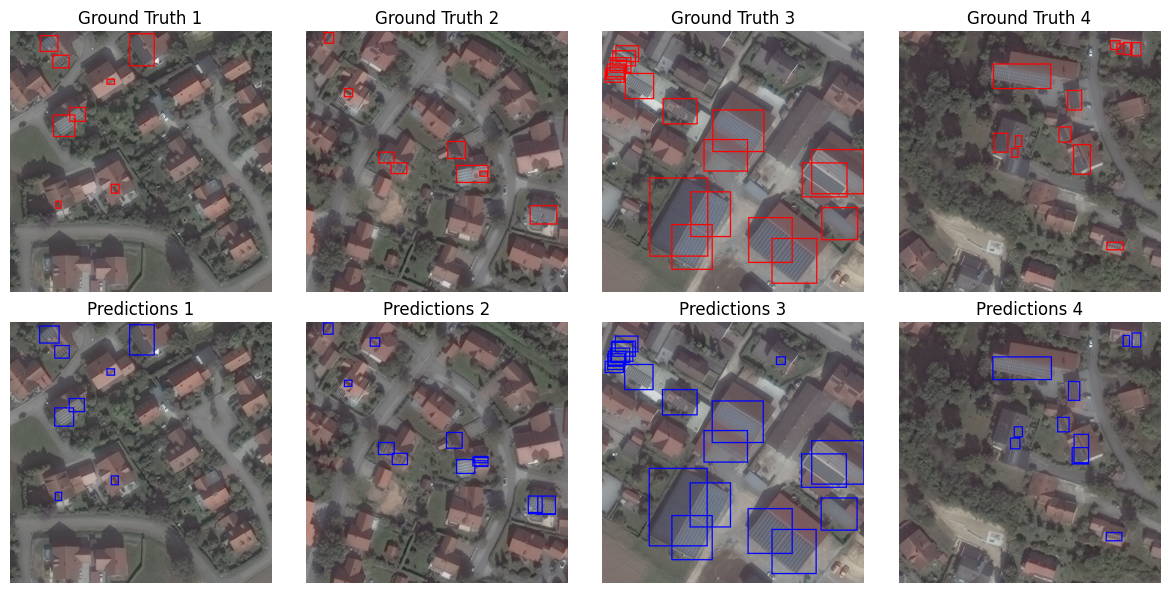

In [278]:
# Plots and compares the predictions and groundtruth labels
def plot_and_compare(n_samples: int = 4):
    fig, axes = plt.subplots(2,n_samples, figsize=(3* n_samples,6))

    for i in range(n_samples):
        img1, img2 = pred_plot(test_img_dir, test_label_dir)

        axes[0,i].imshow(img2)
        axes[0,i].axis("off")
        axes[0,i].set_title(f"Ground Truth {i+1}")

        axes[1,i].imshow(img1)
        axes[1,i].axis("off")
        axes[1,i].set_title(f"Predictions {i+1}")


    plt.tight_layout()
    plt.show()

plot_and_compare(4)

In [18]:
# Retrieves the groundtruth and prediction bounding boxes for a random image in specified directory along with the class_index and confidence scores for predictions
def get_gt_predictions(img_dir, label_dir,include_class_idx=False,include_conf_score=False):
    img_path, label_path = get_random_test_img(img_dir, label_dir)

    predictions = model.predict(img_path,conf=0.25)[0].boxes.cpu()
    gt_boxes = convert_yolo_to_xyxy(open(label_path,"r").read().splitlines(),img_size=416,include_class_idx=include_class_idx)

    coords = np.array(predictions.xyxy)
    conf = np.expand_dims(np.array(predictions.conf),0)
    classes = np.expand_dims(np.array(predictions.cls),0)

    concatenated_preds = coords
    if include_class_idx:
      concatenated_preds = np.concatenate([concatenated_preds,classes.T],axis=-1)
    if include_conf_score:
      concatenated_preds = np.concatenate([concatenated_preds,conf.T],axis=-1)


    print(gt_boxes.shape,concatenated_preds.shape)
    return gt_boxes, concatenated_preds

In [152]:
def preprocess_coords(bbox_1:list,bbox_2:list):
  # YOLO format is (x_center,y_center,width,height)
  x1,y1,w1,h1 = tuple(bbox_1)
  x2,y2,w2,h2 = tuple(bbox_2)

  x1_min = (x1 - w1/2)
  y1_min = (y1 - h1/2)
  x1_max = (x1 + w1/2)
  y1_max = (y1 + h1/2)

  x2_min = (x2 - w2/2)
  y2_min = (y2 - h2/2)
  x2_max = (x2 + w2/2)
  y2_max = (y2 + h2/2)

  return np.array([x1_min,y1_min,x1_max,y1_max]),np.array([x2_min,y2_min,x2_max,y2_max])

In [153]:
from shapely.set_operations import intersection,union
from shapely.geometry import box
from supervision.detection.utils import box_iou_batch

# Calculate IOU score for single pair of boxes
def IOU(bbox_1, bbox_2, is_yolo: bool = False):

    # Convert YOLO format to min-max bounding boxes if needed
    if is_yolo:
        bbox_1, bbox_2 = preprocess_coords(bbox_1, bbox_2)


    b1 = box(bbox_1[0], bbox_1[1], bbox_1[2], bbox_1[3])
    b2 = box(bbox_2[0], bbox_2[1], bbox_2[2], bbox_2[3])
    intersection_area = intersection(b1,b2).area
    union_area = union(b1,b2).area

    return intersection_area / union_area


In [182]:
targets = []
preds = []

# Generating 5 random images along with groundtruth and corresponding predicitions
for i in range(5):
  gt,pred = get_gt_predictions(test_img_dir,label_dir,True,True)
  targets.append(gt)
  preds.append(pred)


image 1/1 /content/dataset/images_data/test/solarpanels_native_3__x0_9721_y0_9614_dxdy_416.tif: 416x416 6 0s, 854.0ms
Speed: 2.4ms preprocess, 854.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)
(6, 5) (6, 6)

image 1/1 /content/dataset/images_data/test/solarpanels_native_1__x0_8598_y0_8885_dxdy_416.tif: 416x416 3 0s, 1064.7ms
Speed: 1.5ms preprocess, 1064.7ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 416)
(2, 5) (3, 6)

image 1/1 /content/dataset/images_data/test/solarpanels_native_1__x0_9824_y0_10503_dxdy_416.tif: 416x416 6 0s, 1350.8ms
Speed: 1.6ms preprocess, 1350.8ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 416)
(6, 5) (6, 6)

image 1/1 /content/dataset/images_data/test/solarpanels_native_3__x0_8690_y0_12315_dxdy_416.tif: 416x416 8 0s, 1175.0ms
Speed: 1.7ms preprocess, 1175.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)
(5, 5) (8, 6)

image 1/1 /content/dataset/images_data/test/solarpanels_native_3__x

In [184]:
# Generates pair-wise IOU score for ground truth and prediction bounding boxes
def batch_IOU(pred_boxes,gt_boxes):

  mat = np.zeros((pred_boxes.shape[0],gt_boxes.shape[0]))

  for i in range(pred_boxes.shape[0]):
    for j in range(gt_boxes.shape[0]):
      mat[i,j] = IOU(pred_boxes[i],gt_boxes[j])

  return mat


In [193]:
# Calculate the precisions and recalls for each image
def calculate_precision_recall(predictions,targets,iou_threshold=0.5):

  precisions = []
  recalls = []


  for prediction,target in zip(predictions,targets):

    tp, fp, fn = 0, 0, 0

    gt_compared = set()

    pair_iou_matrix = batch_IOU(prediction,target)

    for pred in pair_iou_matrix:
      idx_candidates = np.where(pred >= iou_threshold)[0]  # Get matching GT indices

      for idx in sorted(idx_candidates):
          if idx not in gt_compared:
              gt_compared.add(idx)
              tp += 1
              break
      else:
          fp += 1  # If all candidates were already matched, count as FP

    # Compute False Negatives
    fn += len(target) - len(gt_compared)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    precisions.append(precision)
    recalls.append(recall)

  return precisions,recalls

In [267]:
precisions,recalls = calculate_precision_recall(preds,targets)
precisions,recalls

([0.8333333333333334, 0.6666666666666666, 1.0, 0.5, 1.0],
 [0.8333333333333334, 1.0, 1.0, 0.8, 0.8571428571428571])

In [268]:
# returns average precision based  on the precision-recall curve method
def precision_recall_curve(precision,recall):

  precision = np.array(precision)
  recall = np.array(recall)

  recall = np.concatenate([[0],recall,[1]])
  precision = np.concatenate([[1],precision,[0]])

  max_accumulated_precision = np.flip(np.maximum.accumulate(np.flip(precision)))

  avg_precision = np.trapz(max_accumulated_precision,recall)

  return np.round(avg_precision,4)

In [269]:
import supervision as sv
import numpy as np

# Calculate mAP using supervision library methods
mean_average_precision = sv.MeanAveragePrecision.from_tensors(
    predictions=preds,
    targets=targets,
)


print(f" The mAP50 obtained using precision-recall curve is: {precision_recall_curve(precisions,recalls)}")
print(f"The mAP50 obtained using supervision library is: {mean_average_precision.map50}")

 The mAP50 obtained using precision-recall curve is: 0.9286
The mAP50 obtained using supervision library is: 0.902366864042726


### b. Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1)

In [122]:
iou_thresholds = [0.1,0.3,0.5,0.7,0.9]
conf_thresholds = [0.1,0.3,0.5,0.7,0.9]

In [212]:
import supervision as sv

# Calculate the precisions,recalls and f1-score for each pair of iou and conf threshold
precisions = []
recalls = []
f1_scores = []

for iou in iou_thresholds:
  p = []
  r = []
  f = []
  for conf in conf_thresholds:

    confusion_matrix = sv.ConfusionMatrix.from_tensors(
        predictions=preds,
        targets=targets,
        classes=['0'],
        iou_threshold=iou,
        conf_threshold=conf,
    )

    tp = confusion_matrix.matrix[0][0]
    fp = confusion_matrix.matrix[0][1]
    fn = confusion_matrix.matrix[1][0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    p.append(round(precision,3))
    r.append(round(recall,3))
    f.append(round(f1,3))
  precisions.append(p)
  recalls.append(r)
  f1_scores.append(f)

print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")
print(f"F1-scores: {f1_scores}")

Precisions: [[0.885, 0.885, 0.846, 0.846, 0.654], [0.885, 0.885, 0.846, 0.846, 0.654], [0.885, 0.885, 0.846, 0.846, 0.654], [0.808, 0.808, 0.808, 0.808, 0.654], [0.346, 0.346, 0.346, 0.346, 0.269]]
Recalls: [[0.793, 0.793, 0.846, 0.88, 0.944], [0.793, 0.793, 0.846, 0.88, 0.944], [0.793, 0.793, 0.846, 0.88, 0.944], [0.724, 0.724, 0.808, 0.84, 0.944], [0.31, 0.31, 0.346, 0.36, 0.389]]
F1-scores: [[0.836, 0.836, 0.846, 0.863, 0.773], [0.836, 0.836, 0.846, 0.863, 0.773], [0.836, 0.836, 0.846, 0.863, 0.773], [0.764, 0.764, 0.808, 0.824, 0.773], [0.327, 0.327, 0.346, 0.353, 0.318]]


In [253]:
# Storing the obtained values into repsective data frames to use in further steps
df_precision = pd.DataFrame(precisions,columns=conf_thresholds,index=iou_thresholds)
df_recall = pd.DataFrame(recalls,columns=conf_thresholds,index=iou_thresholds)
df_f1 = pd.DataFrame(f1_scores,columns=conf_thresholds,index=iou_thresholds)


In [262]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Plots the given dataframe in table format
def plot_table(dataframe,table_name, xlabel="Confidence Threshold", ylabel="IoU Threshold"):

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


    t = table(ax, dataframe, loc="center", cellLoc="center", colWidths=[0.12] * len(dataframe.columns))


    t.auto_set_font_size(False)
    t.set_fontsize(10)
    t.scale(1.2, 1.2)


    fig.text(0.5, 0.75, xlabel, ha="center", fontsize=9,fontweight="bold")
    fig.text(0.14, 0.50, ylabel, va="center", rotation="vertical", fontsize=9,fontweight="bold")
    ax.set_title(table_name)
    plt.show()

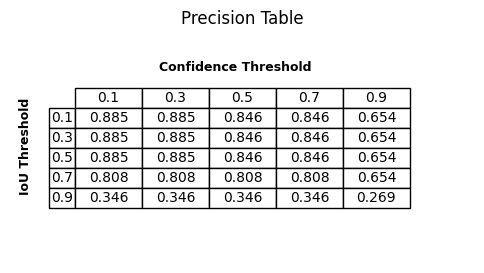

In [263]:
plot_table(df_precision,"Precision Table")

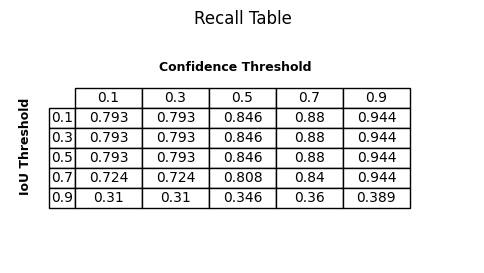

In [264]:
plot_table(df_recall,"Recall Table")

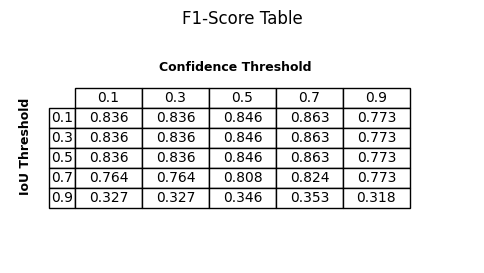

In [265]:
plot_table(df_f1,"F1-Score Table")